In [8]:
import sympy as sp 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import thesis_rcparams
import tstrippy
from astropy import units as u
from astropy import constants as const

## Martos Halo Tidal Tensor: 

This was a fun exercise. Take the Martos halo:

$$ M_\text{enc}(r) = M_0\frac{(r/r_s)^\gamma}{1+(r/r_s)^{\gamma-1}}$$ 

which can be dedimensionalized by the following subs: $s=r/r_s$ and $M'=M/M_0$

$$ M'_\text{enc}(s) =\frac{s^\gamma}{1+s^{\gamma-1}}$$ 

Which is already de-dimensionalized. I can compute the force at any point by taking advantage of spherical symmetry:

$$ F = -\frac{GM_\text{enc}(r)}{r^3}\vec{r}$$

I want to de-dimensionalize this force given that $s=r/r_s$ where $r_s$ is the halo's characteristic length. It follows that $s^2 = x'^2+y'^2+z'^2$. I can now rewrite the dedimensionalized force as: 

$$ F' =-\frac{M'_\text{enc}(s)}{s^3}\vec{s}$$

And it is related to the full force as: $ F=F'F_0$ where

$$F_0 = \frac{GM_0}{r_s^2}$$

and now, we want to find the tidal field. So I can take the jacobian of the transform: 

$$ F_\text{tidal} = \text{J}(F)d\vec{r} $$

And the Jacobian of the transform is given by taken all the derivatives with respect to each component. 

$$
\text{J}(F)= \left(\begin{matrix}
\partial_x F_x & \partial_y F_x & \partial_z F_x \\
\partial_x F_y & \partial_y F_y & \partial_z F_y \\
\partial_x F_z & \partial_y F_z & \partial_z F_z 
\end{matrix}\right)
$$

Given the symmetry of the problem, I can just compute the cross term as well as the parallel term, which will then generalize. 

I solved this in a notebook and here is the result: 

$$
\text{J}(F')=-\frac{M'_\text{enc}(s)}{s^3}\left(\begin{matrix}
1-x'^2s^{-2}f(s) & -x'y's^{-2}f(s) & -x'z's^{-2}f(s)  \\
\dots & 1-y'^2s^{-2}f(s) & -y'z's^{-2}f(s) \\
\dots  & \dots  & 1-z'^2s^{-2}f(s)
\end{matrix}\right)
$$

Where 
$$ f(s) = 2 - \frac{\gamma-1}{1+s^{\gamma-1}}

In [ ]:
def f(s,gamma):
    numerator = 3 + 2*s**(gamma-1) - gamma
    denominator = 1 + s**(gamma-1)
    return numerator/denominator

def mass_profile(s,gamma):
    numerator = s**gamma
    denominator = 1 + s**(gamma-1)
    return numerator/denominator


In [ ]:
s = np.logspace(-3, 2, 100)
gammas = np.arange(1., 5,0.25)
solutions = []
mass_profiles = []
for gamma in gammas:
    f_s = f(s, gamma)
    solutions.append(f_s)
    mass_profile_s = mass_profile(s, gamma)
    mass_profiles.append(mass_profile_s)

/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_49467/4270893159.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('jet', len(gammas))


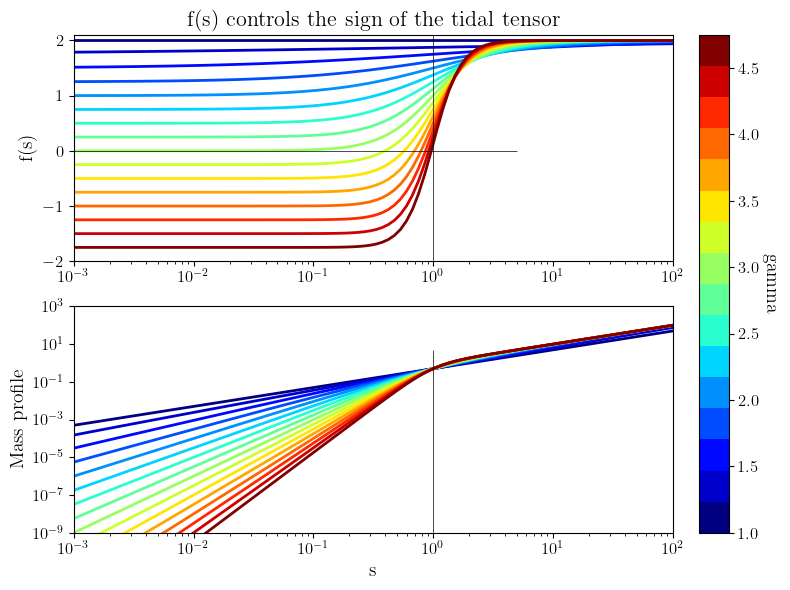

In [ ]:


cmap = mpl.cm.get_cmap('jet', len(gammas))
norm=mpl.colors.Normalize(vmin=min(gammas), vmax=max(gammas))

fig=plt.figure(figsize=(8, 6))
gs=fig.add_gridspec(2, 2, width_ratios=[1, 0.05])
axes=[]
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[1, 0]))
cax=fig.add_subplot(gs[:, 1])
for i, gamma in enumerate(gammas):
    color = cmap(i)
    axes[0].plot(s, solutions[i], label=f'gamma={gamma:.2f}', color=color)
sm=plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=fig.colorbar(sm, cax=cax)
cbar.set_label('gamma', rotation=270, labelpad=15)
axes[0].vlines(1, -2, 2.1, color='black', lw=0.5)
axes[0].hlines(0, 0, 5, color='black', lw=0.5)
axes[0].set_xlim(0, 5)
axes[0].set_ylim(-2, 2.1)
axes[0].set_ylabel('f(s)')
for i, gamma in enumerate(gammas):
    color = cmap(i)
    axes[1].plot(s, mass_profiles[i], label=f'gamma={gamma:.2f}', color=color)
axes[1].vlines(1, 0, 5, color='black', lw=0.5)
axes[1].set_yscale('log')
axes[1].set_ylim(1e-9, 1e3)
axes[0].set_xlim(np.min(s), np.max(s))
axes[1].set_xlim(np.min(s), np.max(s))
axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[1].set_xlabel('s')
axes[0].set_title('f(s) controls the sign of the tidal tensor')
axes[1].set_ylabel('Mass profile')
fig.tight_layout()

An interesting note. 

$\gamma=3$ is a critical value for the value. If it is greater than 3, when are beneath the characteristic radius of the value, each shell 

## Integrate some streams in this potential 

In [27]:
def get_single_orbit(staticgalaxy, initial_conditions, integration_params):
    """
    Run a single orbit with the given static galaxy and initial conditions.
    """
    Nparticle = 1 
    # Set up the integrator

    tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
    tstrippy.integrator.setintegrationparameters(*integration_params)
    tstrippy.integrator.setinitialkinematics(*initial_conditions)

    # Integrate the orbit
    Nstep = integration_params[2]
    xt,yt,zt,vxt,vyt,vzt=tstrippy.integrator.leapfrogintime(Nstep,Nparticle)
    tstrippy.integrator.deallocate()
    return xt[0], yt[0], zt[0], vxt[0], vyt[0], vzt[0]

In [89]:
def compute_vcirc(haloparams, x0):
    G,Mo,rc,gamma,rcut = haloparams
    # get the initial veloicity
    Mr=mass_profile(x0/rc, gamma) * Mo 
    # compute the circular velocity
    v_circ = np.sqrt(G * Mr / x0) 
    return v_circ


In [90]:
def get_xy_plane_initial_conditions(haloparams, x0, eccen):
    """
    Get the initial conditions for the orbit.
    """
    G,Mo,rc,gamma,rcut = haloparams
    # Set up the initial conditions
    x0 = x0 
    y0 = 0.0 
    z0 = 0.0 
    # get the initial veloicity
    v_circ= compute_vcirc(haloparams, x0)
    # pick the velocities 
    vx0 = 0.0 
    vy0 = (1-eccen) * v_circ
    vz0 = 0.0 
    return x0, y0, z0, vx0, vy0, vz0

In [122]:
def get_integration_params(haloparams,x0,initial_time=0,num_orbits=10,divisor=1000):
    """
    Get the integration parameters for the orbit.
    """
    # get the initial veloicity
    v_circ= compute_vcirc(haloparams,x0)
    # set the time characterstic
    tchar = x0/v_circ
    # set the time step
    dt = tchar/divisor
    # set the integration time
    integration_time = np.pi*num_orbits*tchar
    Nstep = int(integration_time/dt)
    return (float(initial_time), dt,Nstep)


In [123]:
unitL = u.kpc
unitV = u.km/u.s
unitT = unitL/unitV
unitM = u.Msun
unitG = unitL*unitV**2/unitM
G=const.G.to(unitG).value

In [124]:
haloname = "allensantillianhalo"
halomass = 1e12
haloradius = float(30)
gamma = 2.02
rcut = float(100)
haloparams = [float(G),halomass,haloradius,gamma,rcut]

In [125]:
# pick the initial orbit 
x0=float(1)
eccen = 0.6
num_orbits = 10
initial_time = 0.0
gamma = 2.02

In [126]:
vcirc= compute_vcirc(haloparams,x0)

In [127]:
haloparams

[4.300917270036279e-06, 1000000000000.0, 30.0, 2.02, 100.0]

In [180]:
x0=3
num_orbits=3
orbiis = []
nsolutions = 5
eccentricities = np.linspace(0, 0.9, nsolutions)
cmap = mpl.colormaps.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, nsolutions)]
for i in range(nsolutions):
    eccen = eccentricities[i]
    staticgalaxy = (haloname, haloparams)
    initial_conditions = get_xy_plane_initial_conditions(haloparams, x0, eccen)
    integration_params = get_integration_params(haloparams,x0,initial_time,num_orbits)
    xt,yt,zt,vxt,vyt,vzt = get_single_orbit(staticgalaxy, initial_conditions, integration_params)
    orbiis.append((xt,yt,zt,vxt,vyt,vzt))

In [181]:
AXIS={"aspect":"equal", "adjustable":"box"}
sm = plt.cm.ScalarMappable(cmap=cmap)

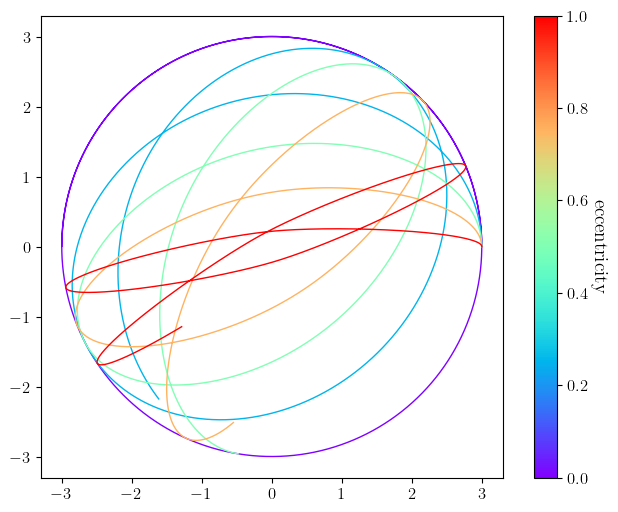

In [182]:
fig,axis=plt.subplots(figsize=(8, 6))
for i in range(nsolutions):
    xt,yt,zt,vxt,vyt,vzt = orbiis[i]
    color = colors[i]
    axis.plot(xt, yt, color=color, lw=1)
axis.set(**AXIS)
cbar=fig.colorbar(sm, ax=axis)
cbar.set_label('eccentricity', rotation=270, labelpad=15)

In [191]:
# now do a range of gamma
gammas = np.arange(0, 5.0+1, 1)
x0=1
num_orbits=3
eccen = 0.6
nsolutions = len(gammas)
orbiis = []
cmap = mpl.colormaps.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, nsolutions)]
for i in range(nsolutions):
    gamma = gammas[i]
    haloparams = [float(G),halomass,haloradius,gamma,rcut]
    staticgalaxy = (haloname, haloparams)
    initial_conditions = get_xy_plane_initial_conditions(haloparams, x0, eccen)
    integration_params = get_integration_params(haloparams,x0,initial_time,num_orbits)
    xt,yt,zt,vxt,vyt,vzt = get_single_orbit(staticgalaxy, initial_conditions, integration_params)
    orbiis.append((xt,yt,zt,vxt,vyt,vzt))

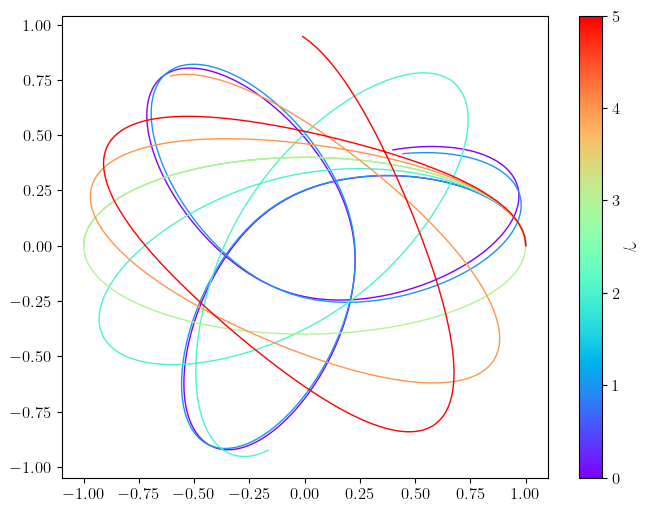

In [192]:
norm = mpl.colors.Normalize(vmin=min(gammas), vmax=max(gammas))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
AXIS={"aspect":"equal", "adjustable":"box"}

fig,axis=plt.subplots(figsize=(8, 6))
for i in range(nsolutions):
    xt,yt,zt,vxt,vyt,vzt = orbiis[i]
    color = colors[i]
    axis.plot(xt, yt, color=color, lw=1)
axis.set(**AXIS)
cbar=fig.colorbar(sm, ax=axis)
cbar.set_label(r'$\gamma$', rotation=270, labelpad=15)